# Deep Technical Analysis with Coinmarketcap.com Price History

In this notebook we well generate a 3 dimensional price tensor of coin history data. The price tensor will be of dimensions mxnxf. Where m is number of coins, n is number of days, and f is number of features.

Once we have our price tensor, we will implement stochastic batch learning (SBL). SBL will iteratively sample n<sub>b</sub> days of history for a random coin, beginning at a random time t<sub>b</sub>, and ending at t<sub>b</sub> + n<sub>b</sub> + 1. Given such a sample, the algo take input t<sub>b</sub> to t<sub>b</sub> + n<sub>b</sub>, and will attempt to predict t<sub>b</sub> + n<sub>b</sub> + 1.

Price data in t<sub>b</sub> to t<sub>b</sub> + n<sub>b</sub> will be normalized with respect to closing price at t<sub>b</sub> + n<sub>b</sub> + 1

The architecture will be an implementation of the mini-machine topology, using CNN as outlined in [this paper](https://arxiv.org/pdf/1706.10059.pdf)

### Creating The Price Tensor

In [1]:
from Coinmarketcap.coinmarketcap import CoinMarketcap
import numpy as np
import pandas as pd
import xarray as xr
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Get a list of coin objects for the top 100 coins from coinmarketcap.com
cmk = CoinMarketcap()
coins = cmk.coins()

In [ ]:
# Change 'read_history' to 'get_history' to refresh your local cache
start, end = '20140101', '20180228'
price_tensor = {coin.name:coin.read_history(start=start,end=end) for coin in coins}
price_tensor = pd.Panel(price_tensor)

In [38]:
price_tensor.isna().sum()

,0x,Aeternity,Aion,Ardor,Ark,Augur,Bancor,Basic Attenti...,Binance Coin,BitShares,...,Verge,Veritaseum,Vertcoin,Waltonchain,Waves,ZClassic,ZCoin,Zcash,Zilliqa,aelf
Unnamed: 0,1323,1247,1386,1002,1176,764,1264,1247,1301,201,...,297,1254,19,1334,883,1044,1009,1032,1485,1450
Date,1323,1247,1386,1002,1176,764,1264,1247,1301,201,...,297,1254,19,1334,883,1044,1009,1032,1485,1450
Open,1323,1247,1386,1002,1176,764,1264,1247,1301,201,...,297,1254,19,1334,883,1044,1009,1032,1485,1450
High,1323,1247,1386,1002,1176,764,1264,1247,1301,201,...,297,1254,19,1334,883,1044,1009,1032,1485,1450
Low,1323,1247,1386,1002,1176,764,1264,1247,1301,201,...,297,1254,19,1334,883,1044,1009,1032,1485,1450
Close,1323,1247,1386,1002,1176,764,1264,1247,1301,201,...,297,1254,19,1334,883,1044,1009,1032,1485,1450
Volume,1323,1247,1386,1002,1176,764,1264,1247,1301,201,...,297,1254,19,1334,883,1044,1009,1032,1485,1450
Market Cap,1323,1247,1386,1002,1176,764,1264,1247,1301,201,...,297,1254,19,1334,883,1044,1009,1032,1485,1450


In [39]:
price_tensor.shape

(100, 1520, 8)

### Fill Missing Values

In [42]:
# Date column is the same for every coin, copy from Bitcoin which we know has all its data
for coin in price_tensor:
    price_tensor[coin]['Date'] = price_tensor['Bitcoin']['Date']
    
# Some missing values are encoded with '-'
price_tensor = price_tensor.replace('-', np.nan)

# price_tensor = price_tensor.fillna(1)
price_tensor = price_tensor.ffill()

# Check to see if any null remain
price_tensor.isna().sum()


/home/shawn/.virtualenvs/733Project/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: 
Panel is deprecated and will be removed in a future version.
The recommended way to represent these types of 3-dimensional data are with a MultiIndex on a DataFrame, via the Panel.to_frame() method
Alternatively, you can use the xarray package http://xarray.pydata.org/en/stable/.
Pandas provides a `.to_xarray()` method to help automate this conversion.

  


,0x,Aeternity,Aion,Ardor,Ark,Augur,Bancor,Basic Attenti...,Binance Coin,BitShares,...,Verge,Veritaseum,Vertcoin,Waltonchain,Waves,ZClassic,ZCoin,Zcash,Zilliqa,aelf
Unnamed: 0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Date,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Open,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
High,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Low,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Close,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Volume,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Market Cap,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Plotting All Marketcaps

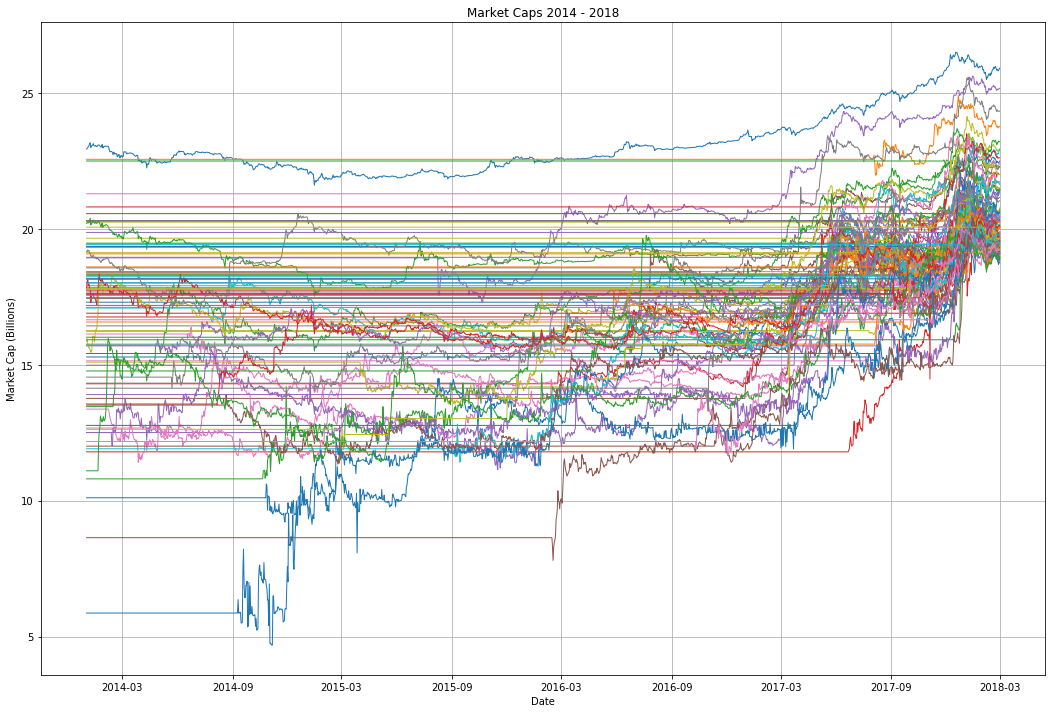

In [43]:
#x = btc_history['dt']
#y = btc_history['Market Cap'] / 1e9
plt.clf()
plt.figure(figsize=(18,12))
x = pd.to_datetime(price_tensor['Bitcoin']['Date'])
for coin in price_tensor.items:
    y = np.log(pd.to_numeric(price_tensor[coin]['Market Cap']))
    plt.plot(x, y, linewidth=1, label=coin)

plt.xlabel('Date')
#plt.xticks(np.arange(1900, 2020, 10.0))
plt.ylabel('Market Cap (Billions)')
plt.title("Market Caps 2014 - 2018")
#plt.legend(loc='upper left')
plt.grid(True)

In [44]:
from DeepLearning.CNN import Evaluator

I am a coin evaluator


In [45]:
price_tensor.shape

(100, 1520, 8)

## Now for some Deep Learning
We will now use convulutional networks to evaluate coins and predict price movement

### First convert date to two features: Day of Year, and Month

In [72]:
training_example = price_tensor['Bitcoin']
doy = pd.to_datetime(price_tensor['Bitcoin']['Date']).apply(lambda x: x.dayofyear)
month = pd.to_datetime(price_tensor['Bitcoin']['Date']).apply(lambda x: x.month)
training_example['doy'] = doy
training_example['month'] = month
training_example = training_example.drop(['Date', 'Unnamed: 0'], axis=1)

In [73]:
training_example

,Open,High,Low,Close,Volume,Market Cap,doy,month
0,10687.2,11089.8,10393.1,10397.9,6936190000,180510000000,59,2
1,10393.9,10878.5,10246.1,10725.6,6966180000,175536000000,58,2
2,9669.43,10475,9501.73,10366.7,7287690000,163283000000,57,2
3,9796.42,9923.22,9407.06,9664.73,5706940000,165407000000,56,2
4,10287.7,10597.2,9546.97,9813.07,6917930000,173682000000,55,2
5,9937.07,10487.3,9734.56,10301.1,7739500000,167746000000,54,2
6,10660.4,11039.1,9939.09,10005,8040080000,179936000000,53,2
7,11372.2,11418.5,10479.1,10690.4,9405340000,191927000000,52,2
8,11231.8,11958.5,11231.8,11403.7,9926540000,189536000000,51,2
9,10552.6,11273.8,10513.2,11225.3,7652090000,178055000000,50,2


In [77]:
training_example.T.shape

(8, 1520)

In [78]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
import keras

Using TensorFlow backend.


ModuleNotFoundError: No module named 'tensorflow'